In [1]:
import matplotlib.pyplot as plt
import os, re, pickle
import scipy.io
from collections import defaultdict
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
lion,bear,bird,cat,cow,dog,elephant,giraffe,horse,person,sheep,zebra

In [2]:
animate_class = [
    "lion",
    "bear",
    "bird",
    "cat",
    "cow",
    "dog",
    "elephant",
    "giraffe",
    "horse",
    "person",
    "sheep",
    "zebra",
]

analysis_legend = {
    'DET vs FullGradCam' : "DET",
    'EXP vs ODAM' : "EXP",
    'PV vs FullGradCam' : "PV"
}

color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "#0072BD",
    "DET-GrpE vs FullGradCam":  "cyan",
    
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",

    "PV vs FullGradCam":        "purple",
    "PV-GrpF vs FullGradCam":   "pink",
    "PV-GrpE vs FullGradCam":   "magenta",
}

alpha = 0.3

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


## MSCOCO Paired-t Test
Grouped by Backbone vs Neck
Over images

In [45]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM','PV vs FullGradCam']

PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/mscoco/remove_empty_saliency/mscoco_PCC_all.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/mscoco/remove_empty_saliency/mscoco_PCC_all.pickle','rb'))

dfs_orig = {}

# reverse layer numbering
for analysis in focused_analysis:
    df = pd.DataFrame.from_dict(PCC_all[analysis])
    
    rename_mapping = {}
    for col in df.columns:
        rename_mapping[col] = 18-col

    dfs_orig[analysis] = df.rename(columns=rename_mapping)[list(rename_mapping.keys())[:-4]].T

dfs_orig = {}
for analysis in focused_analysis:
    dfs_orig[analysis] = pd.read_csv(f'/mnt/h/jinhan/xai/results/mscoco/remove_empty_saliency/mscoco_PCC_{analysis.replace(" ","_")}.csv',index_col=0)

dfs = defaultdict(defaultdict)
for analysis in focused_analysis:
    animate_imgs = [col for col in dfs_orig[analysis].columns if (any(keyword in col for keyword in animate_class) and 'hot dog' not in col)]
    inanimate_imgs = [col for col in dfs_orig[analysis].columns if (col not in animate_imgs)]
    dfs['animate'][analysis] = dfs_orig[analysis][animate_imgs]
    dfs['inanimate'][analysis] = dfs_orig[analysis][inanimate_imgs]

###

from scipy.stats import ttest_rel

for category in ['mixed','animate','inanimate']:

    if category == 'mixed':
        df = dfs_orig
    else:
        df = dfs[category]

    p_values = defaultdict()

    neck_pcc = defaultdict(list)
    backbone_pcc = defaultdict(list)
    for analysis in focused_analysis:
        print()
        print(analysis)
        backbone_pcc[analysis] = df[analysis].loc[1:8].mean().tolist()
        neck_pcc[analysis] = df[analysis].loc[9:13].mean().tolist()

        result = ttest_rel(neck_pcc[analysis], backbone_pcc[analysis])
        print(f"t({len(df[analysis].columns)-1})={np.format_float_positional(result.statistic,precision=3, unique=False, fractional=False, trim='k')}, p={np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k')}")
        print(f"Backbone: M={np.format_float_positional(np.average(backbone_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(backbone_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}")
        print(f"Neck: M={np.format_float_positional(np.average(neck_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(neck_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')}")

        p_values[analysis] = float(np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k'))

    # Bar scatter plot
    # x = np.arange(len(focused_analysis))  # the label locations
    width = 0.4  # the width of the bars
    np.random.seed(123)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 10
    plt.rcParams['figure.constrained_layout.use'] = True
    
    fig, ax = plt.subplots(layout='constrained')

    x_labels = ['Backbone','  Neck','Backbone','  Neck','Backbone','  Neck']
    x_labels_loc = []

    multiplier1 = 0
    offset1 = width * multiplier1

    multiplier2 = 1
    offset2 = width * multiplier2

    # Backbone
    for x, analysis in enumerate(focused_analysis):
        # Backbone
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k'))
        rects = ax.bar(x + offset1, 
                    backbone_value,
                    yerr=float(np.format_float_positional(np.std(backbone_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')), 
                    capsize=12,
                    width=width, 
                    color=(0,0,0,0), 
                    edgecolor=color_code[analysis], 
                    label=analysis)
        x_labels_loc.append(x+offset1)
        x_labels_loc.append(x+offset2)
        # ax.bar_label(rects, padding=3)

    for x, analysis in enumerate(focused_analysis):
        # Neck
        neck_value = float(np.format_float_positional(np.average(neck_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k'))
        rects = ax.bar(x + offset2, 
                    neck_value,
                    yerr=float(np.format_float_positional(np.std(neck_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k')), 
                    capsize=12,
                    width=width, 
                    color=(0,0,0,0), 
                    edgecolor=color_code[analysis], 
                    label=analysis)
        # ax.bar_label(rects, padding=3)

    ax.legend(labels=['DET','EXP','PV'],
                loc='upper left', ncols=3, 
                fontsize=14,
                handletextpad=1,
                columnspacing=4,
                handlelength=3)
    # ax.legend(handletextpad=0.5)

    for x, analysis in enumerate(focused_analysis):
        ax.scatter(x + np.random.random(len(backbone_pcc[analysis])) * width - width / 2, backbone_pcc[analysis], color=color_code[analysis],alpha=0.1)
        ax.scatter(x + offset2 + np.random.random(len(neck_pcc[analysis])) * width - width / 2, neck_pcc[analysis], color=color_code[analysis],alpha=0.1)

    for x, analysis in enumerate(focused_analysis):
        # Backbone
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k'))
        backbone_height = backbone_value + 0.9 * np.std(backbone_pcc[analysis])
        neck_value = float(np.format_float_positional(np.average(neck_pcc[analysis]),precision=3, unique=False, fractional=False, trim='k'))
        neck_height = neck_value + 0.9 * np.std(neck_pcc[analysis])

        if p_values[analysis] < 0.001: text = "          ***"
        elif p_values[analysis] < 0.01: text = "          **"
        elif p_values[analysis] < 0.05: text = "          *"
        elif p_values[analysis] < 0.1: text = "          †"
        else: text  = '          ns'
        # else: text = f"p = {p_values[analysis]}"
        def label_diff(i,j,text,X,Y):
            x = (X[i]+X[j])/2
            y = 1.1*max(Y[i], Y[j])
            dx = abs(X[i]-X[j])

            props = {'connectionstyle':'bar','arrowstyle':'-',\
                        'shrinkA':20,'shrinkB':20,'linewidth':1}
            ax.annotate(text, xy=(X[i],y*1.1), zorder=10, fontsize=20, ha='center')
            ax.annotate('', xy=(X[i],y*0.88), xytext=(X[j],y*0.88), arrowprops=props,ha='center')

        label_diff(0,1,text,[x+offset1*0.8,x+offset2*1.2],[backbone_height,neck_height])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('PCC',fontsize=20, fontname='Times New Roman Bold')
    # ax.set_title('Yolo-v5s MSCOCO',fontsize=20,fontname='Times New Roman Bold')
    ax.set_xticks(x_labels_loc, x_labels)
    ax.tick_params(labelsize=18)
    ax.set_ylim(-0.05, 1)
    ax.set_ylabel('PCC')

    ratio = 0.6
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

    plt.title(f'MSCOCO {category}')
    plt.show()
    # fig.savefig(f'/mnt/h/jinhan/xai/results/mscoco/mscoco_bar_scatter_plot')

# BDD


vehicle DET vs FullGradCam
t(85)=5.86, p=0.0000000854
Backbone: M=0.43, std=0.133
Neck: M=0.489, std=0.147

human DET vs FullGradCam
t(67)=3.62, p=0.000559
Backbone: M=0.381, std=0.115
Neck: M=0.414, std=0.131

vehicle DET-GrpF vs FullGradCam
t(85)=5.84, p=0.0000000913
Backbone: M=0.427, std=0.133
Neck: M=0.487, std=0.148

human DET-GrpF vs FullGradCam
t(67)=3.50, p=0.000821
Backbone: M=0.375, std=0.115
Neck: M=0.408, std=0.13

vehicle DET-GrpE vs FullGradCam
t(85)=5.61, p=0.000000248
Backbone: M=0.404, std=0.130
Neck: M=0.458, std=0.141

human DET-GrpE vs FullGradCam
t(67)=3.19, p=0.00216
Backbone: M=0.354, std=0.123
Neck: M=0.382, std=0.148

vehicle EXP vs ODAM
t(85)=7.04, p=0.000000000461
Backbone: M=0.485, std=0.117
Neck: M=0.600, std=0.158

human EXP vs ODAM
t(67)=7.54, p=0.000000000162
Backbone: M=0.489, std=0.0811
Neck: M=0.601, std=0.0920

vehicle EXP-GrpF vs ODAM
t(85)=7.05, p=0.000000000438
Backbone: M=0.485, std=0.119
Neck: M=0.602, std=0.160

human EXP-GrpF vs ODAM
t(67)=7

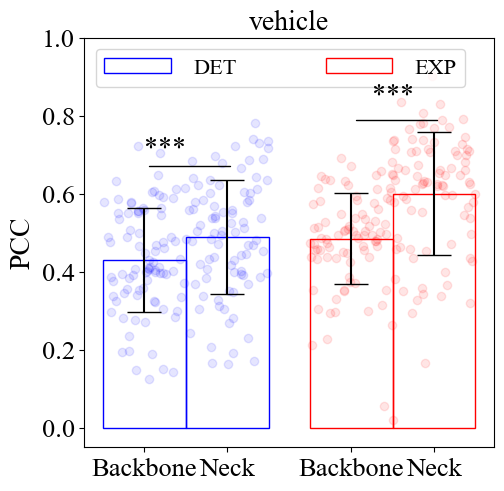

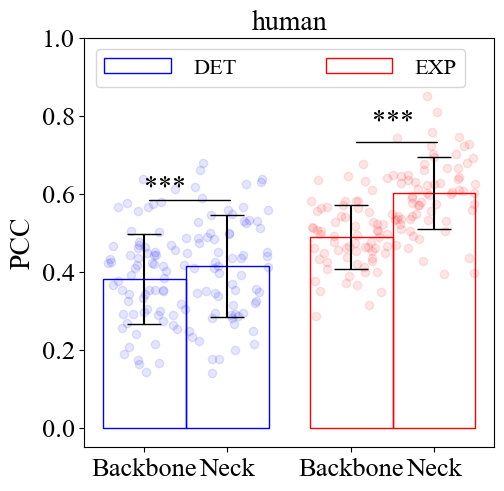

In [43]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']

PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/remove_empty_saliency/bdd_PCC_all.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/remove_empty_saliency/bdd_PCC_all.pickle','rb'))

from scipy.stats import ttest_rel

split_layer = 18 - 7 # included in backbone

p_values = defaultdict(lambda: defaultdict(list))

neck_pcc_all = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
backbone_pcc_all = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
neck_pcc = defaultdict(lambda: defaultdict(list))
backbone_pcc = defaultdict(lambda: defaultdict(list))
for analysis, d0 in PCC_all.items():
    for category, d1 in d0.items():
        print()
        print(f"{category} {analysis}")
        for layer, d2 in d1.items():
            for img, pcc in d2.items():
                if layer in range(split_layer,18):
                    backbone_pcc_all[category][analysis][img].append(pcc)
                elif layer in range(5,split_layer):
                    neck_pcc_all[category][analysis][img].append(pcc)

        for img in backbone_pcc_all[category][analysis].keys():
            backbone_pcc[category][analysis].append(np.average(backbone_pcc_all[category][analysis][img]))
            neck_pcc[category][analysis].append(np.average(neck_pcc_all[category][analysis][img]))

        result = ttest_rel(neck_pcc[category][analysis], backbone_pcc[category][analysis])
        print(f"t({len(PCC_all[analysis][category][12])-1})={np.format_float_positional(result.statistic,precision=3, unique=False, fractional=False, trim='k')}, p={np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k')}")
        print(f"Backbone: M={np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}")
        print(f"Neck: M={np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}, std={np.format_float_positional(np.std(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')}")

        p_values[category][analysis] = float(np.format_float_positional(result.pvalue,precision=3, unique=False, fractional=False, trim='k'))

for category in ['vehicle','human']:
    # Bar scatter plot
    # x = np.arange(len(focused_analysis))  # the label locations
    width = 0.4  # the width of the bars
    np.random.seed(123)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 10

    fig, ax = plt.subplots(layout='constrained')

    x_labels = ['Backbone','Neck','Backbone','Neck']
    x_labels_loc = []

    multiplier1 = 0
    offset1 = width * multiplier1

    multiplier2 = 1
    offset2 = width * multiplier2

    # Backbone
    for x, analysis in enumerate(focused_analysis):
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k'))
        rects = ax.bar(x + offset1, 
                    backbone_value,
                    yerr=float(np.format_float_positional(np.std(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')), 
                    capsize=12,
                    width=width, 
                    color=(0,0,0,0), 
                    edgecolor=color_code[analysis], 
                    label=analysis)
        x_labels_loc.append(x+offset1)
        x_labels_loc.append(x+offset2)
        # ax.bar_label(rects, padding=3)

    for x, analysis in enumerate(focused_analysis):
        neck_value = float(np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')),
        rects = ax.bar(x + offset2, 
            neck_value,
            yerr=float(np.format_float_positional(np.std(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')), 
            capsize=12,
            width=width, 
            color=(0,0,0,0), 
            edgecolor=color_code[analysis], 
            label=analysis)
        # ax.bar_label(rects, padding=3)
    
    ax.legend(labels=['DET','EXP'], 
              loc='upper left', ncols=3, 
              fontsize=16,
              handletextpad=1,
              columnspacing=4,
              handlelength=3)

    for x, analysis in enumerate(focused_analysis):
        backbone_value = float(np.format_float_positional(np.average(backbone_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k'))
        backbone_height = backbone_value + 0.9 * np.std(backbone_pcc[category][analysis])
        neck_value = float(np.format_float_positional(np.average(neck_pcc[category][analysis]),precision=3, unique=False, fractional=False, trim='k')),
        neck_height = neck_value + 0.9 * np.std(neck_pcc[category][analysis])

        if p_values[category][analysis] < 0.001: text = "***"
        elif p_values[category][analysis] < 0.01: text = "**"
        elif p_values[category][analysis] < 0.05: text = "*"
        elif p_values[category][analysis] < 0.1: text = "†"
        else: text  = 'ns'       
        def label_diff(i,j,text,X,Y):
            x = (X[i]+X[j])/2
            y = 1.1*max(Y[i], Y[j])
            dx = abs(X[i]-X[j])

            props = {'connectionstyle':'bar','arrowstyle':'-',\
                        'shrinkA':20,'shrinkB':20,'linewidth':1}
            ax.annotate(text, xy=(X[i]*1.1,y*1.02), zorder=10, fontsize=20)
            ax.annotate('', xy=(X[i],y*0.88), xytext=(X[j],y*0.88), arrowprops=props,ha='center')

        label_diff(0,1,text,[x+offset1*0.9,x+offset2*1.1],[backbone_height,neck_height])

    for x, analysis in enumerate(focused_analysis):
        ax.scatter(x + np.random.random(len(backbone_pcc[category][analysis])) * width - width / 2, backbone_pcc[category][analysis], color=color_code[analysis],alpha=0.1)
        ax.scatter(x + offset2 + np.random.random(len(neck_pcc[category][analysis])) * width - width / 2, neck_pcc[category][analysis], color=color_code[analysis],alpha=0.1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('PCC',fontsize=20)
    # ax.set_title(f'Yolo-v5s {category.capitalize()}',fontsize=20)
    ax.set_xticks(x_labels_loc, x_labels)
    ax.tick_params(labelsize=19)
    ax.set_ylim(-0.05,1)
    ax.set_ylabel('PCC',fontsize=20)

    ratio = 1
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

    plt.title(category,fontsize=20)

    plt.show()
    # fig.savefig(f'/mnt/h/jinhan/xai/results/bdd/bdd_{category}_bar_scatter_plot_240604')